Preliminaries

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Fixed Parameters

In [2]:
# full frequency band
high_λ = 8.4e9 # Hz
low_λ = 7.25e9 # Hz

# reception band - LHCP
high_λ_r = 7.75e9 # Hz
low_λ_r = 7.25e9 # Hz

# transmission band - RHCP
high_λ_t = 8.4e9 # GHz
low_λ_t = 7.9e9 # GHz

# gain
antenna_gain = 31 # dBi
beamwidth = 10 # deg

# steering w/ motorized junction
steer_Ez_low = 40 # deg
steer_Ez_high = 90 # deg
steer_Ez = 50 # deg
steer_Az = 360 # deg 

# bandwidth
bandwidth = 1.15e9 # Hz

# speed of light
c = 3e8 # m/s

In [3]:
# Constants
c = 3e8  # speed of light (m/s)

# Fixed Parameters
high_f = 8.4e9  # GHz to Hz
low_f = 7.25e9  # GHz to Hz
center_freq = (high_f + low_f) / 2  # Center frequency in Hz
wavelength = c / center_freq  # Wavelength in meters

# Performance Parameters
azimuth_resolution = 0.25  # meters
swath = 5e3  # 5 x 5 km, convert to meters
nominal_scene_size = swath  # meters
slant_range_resolution = 0.3  # meters
look_angle_range_low = 25  # degrees
look_angle_range_high = 50  # degrees

# Phased Array Parameters
beamwidth_deg = 10  # desired beamwidth in degrees
beamwidth_rad = np.deg2rad(beamwidth_deg)  # convert beamwidth to radians

# Step 1: Element Spacing
# To avoid grating lobes, element spacing (d) should be less than or equal to lambda / 2
element_spacing = wavelength / 2  # meters
print(f"Element Spacing: {element_spacing:.4f} m")

# Step 2: Array Size Calculation
# The total array size (D) is related to the beamwidth by the formula: 
# D = lambda / beamwidth_rad
array_size = wavelength / beamwidth_rad  # meters
print(f"Array Size (Side length for square array): {array_size:.2f} m")

# Step 3: Number of Elements (N)
# For a square array, the number of elements per side (N_x) can be approximated by:
N_x = array_size / element_spacing
N_y = N_x  # Assuming a square array
N_elements = int(N_x * N_y)  # Total number of elements in the array
print(f"Number of Elements: {N_elements} elements")

# Step 4: Swath Calculation
# Swath width = R * theta, assuming R is the range at average look angle
average_look_angle = (look_angle_range_low + look_angle_range_high) / 2
R = swath / np.sin(np.deg2rad(average_look_angle))  # slant range distance in meters
required_beamwidth = swath / R  # in radians
required_beamwidth_deg = np.rad2deg(required_beamwidth)
print(f"Required Beamwidth: {required_beamwidth_deg:.2f} degrees")

# Step 5: Effective Aperture Reduction due to Steering
# As the beam is steered electronically, the effective aperture decreases:
steering_angle = 50  # degrees, steering from boresight
steering_loss_factor = np.cos(np.deg2rad(steering_angle))
effective_aperture = array_size * steering_loss_factor  # reduced aperture size
print(f"Effective Aperture at {steering_angle} degrees: {effective_aperture:.2f} m")

# Step 6: SNR Calculation (Same as before, assuming some parameters)
P_t = 30  # Transmit power in dBm
NF = 5  # Noise figure in dB
L_other = 2  # Other losses in dB
L_fs = 130.51  # Free-space path loss for example case (already calculated earlier)
G_r = 31  # Receiver antenna gain in dBi
G_t = 31  # Transmit antenna gain in dBi

# Received signal power (simplified link budget):
P_r = P_t + G_t + G_r - L_fs - L_other  # in dBm

# Noise power calculation
P_n = -174 + 10 * np.log10(bandwidth) + NF  # Noise power in dBm

# SNR
SNR = P_r - P_n  # in dB
print(f"SNR: {SNR:.2f} dB")


Element Spacing: 0.0192 m
Array Size (Side length for square array): 0.22 m
Number of Elements: 131 elements
Required Beamwidth: 34.88 degrees
Effective Aperture at 50 degrees: 0.14 m
SNR: 37.88 dB


Define functions for calculators

In [4]:
# Define orbital velocity of satellites
def orbital_velocity(h):
    # Given parameters:
    # h: altitude

    # Nongiven parameters:
    # GM_earth: GM of Earth 
    GM_earth = 398600.435507 # km^3 * s^-2
    return np.sqrt(GM_earth/h) # km/s

# Define dist/range to the target from antenna?
def range(t):
    # Given parameters:
    # t: propagation time 

    # Nongiven parameters:
    # c: speed of light in vacuum
    c = 3e8 # m/s
    # Calculate Range
    R = 0.5*c*t # the radar signal traveled twice the distance measured
    return R

def Δt(x_r):
    # Given parameters:
    # x_r = slant range resolution
    # τ = effective time lemgth

    # Nongiven parameters:
    # c: speed of light in vacuum
    c = 3e8 # m/s
    print(2*x_r/c)  

# Define effective pulse length
def τ(B):
    # Given parameters:
    # B: bandwidth

    τ = 1/B
    return τ
    
# Define slant range direction
def x_r(τ):
    # Nongiven parameters:
    # c: speed of light in vacuum
    c = 3e8 # m/s

    x_r = (c*τ)/2
    return x_r

# Define instantaneous frequency
def f(t, f0, B, τ_p):
    # Given parameters:
    # τ_p: physical pulse length
    # B: bandwidth
    f = f0 + (B/τ_p)*t # for -τ_p/2 <= t <= τ_p/2
    return f

# Define corresponding signal amplitude
def A(t, f0, B, τ_p):
    # Given parameters:
    # τ_p: physical pulse length
    # B: bandwidth

    A = np.cos(2*np.pi * (f0*t + (B/(2(τ_p))*t**2)))
    return A

# Define ground range resolution
def x_g(τ, θ):
    # Given parameters:
    # θ: incidence angle

    # Nongiven parameters:
    # c: speed of light in vacuum
    c = 3e8 # m/s
    x_g = (c*τ)/(2*np.sin(θ))
    return x_g

# Define Receieved (RX) power:
def Pr(Pt, GA, Ae, σ, R, L_radar, L_atmos): # W
    # Given parameters: 
    # Pt: transmitter signal power (W)
    # GA: transmitter antenna gain factor
    # Ae: receiver antenna effective area (m^2)
    # σ: target radar cross section (m^2)
    # R: distance of sensor to the surface of the Earth (range vec from tar to antenna) (m)
    # L_atmos = atmospheric loss factor due to the propagating wave
    # L_radar = microwave transmission loss factor due to miscellaneous sources

    numerator = Pt * GA * Ae * σ
    denominator = (4*np.pi)**2 * R**4 * L_radar * L_atmos
    Pr = numerator/denominator
    return Pr

# Define effective noise power that the signal must compete w/ at the antenna is given approx by:
def Nr(FN, BN, T=290):
    # Given parameters:
    # FN = system noise factor for the reciever
    # BN = noise bandwidth at the antenna port

    # Nongiven parameters:
    # k = 1.38x10^-23 J/K
    # T ~ 290 K: nominal scene noise temperature
    k = 1.380658e-23
    Nr = k*T*FN*BN
    return Nr

# Define Signal-to-Noise Ratio at the RX antenna port 
def SNR_antenna(Pt, GA, Ae, σ, R, L_radar, L_atmos, Nr):
    # Given parameters: 
    # Pt: radar signal power (P_t)
    # G: antenna gain
    # λ (lambda): radar wavelength
    # σ (sigma): radar cross section
    # R: distance of sensor to the surface of the Earth
    # T0: antenna temperature
    # Bn: bandwidth of the radar pulse
    # F: noise figure 

    # Nongiven parameters:
    # Boltzmann Constant
    k = 1.380658e-23 # JK^-1
    numerator = Pt * GA * Ae * σ
    denominator = (4*np.pi)**2 * R**4 * L_radar * L_atmos * Nr
    SNR = numerator/denominator
    return SNR


# Define SNR in the SAR image
def SNR_image(SNR_ant, Gr, Ga):
    # Gr: SNR gain due to range processing (pulse compression)
    # Ga: SNR gain due to azimuth processing (coherent pulse integration)
    signal_processing_gain = Gr * Ga
    SNR_img = SNR_ant * signal_processing_gain
    return SNR_img



<>:64: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:64: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\algam\AppData\Local\Temp\ipykernel_2508\2147638461.py:64: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  A = np.cos(2*np.pi * (f0*t + (B/(2(τ_p))*t**2)))


In [5]:
# Platform Config
v = orbital_velocity(615) # 615 km orbit around Earth
h = 615 # km for now

# Radar signal config
f = 7.825e9 # frequency
λ  = 0.03831214 # m
bw = 1.15e9 # Hz

# antenna dimensions - to be manipulated
daz = 0.22 # m
dele = 0.22 # m



In [6]:
def ap2beamwidth(antenna_dimensions, wavelength):
    """
    Calculate the beamwidth of an antenna given its dimensions and wavelength.
    
    Parameters:
    - antenna_dimensions (list or tuple): Antenna dimensions [daz, dele] in meters.
    - wavelength (float): Wavelength of the radar signal in meters.
    
    Returns:
    - beamwidth (numpy array): Beamwidth in degrees [Azimuth, Elevation].
    """
    # Convert dimensions to radians
    daz = antenna_dimensions[0]
    dele = antenna_dimensions[1]
    
    # Calculate beamwidth in radians
    beamwidth_azimuth = 70.0 * wavelength / daz
    beamwidth_elevation = 70.0 * wavelength / dele
    
    # Convert beamwidth from radians to degrees
    beamwidth_azimuth_deg = np.degrees(beamwidth_azimuth)
    beamwidth_elevation_deg = np.degrees(beamwidth_elevation)
    
    return np.array([beamwidth_azimuth_deg, beamwidth_elevation_deg])

def calculate_antenna_diameter(beamwidth_deg, wavelength):
    """
    Calculate the required antenna dimension for a given beamwidth.
    
    Parameters:
    - beamwidth_deg (float): Desired beamwidth in degrees.
    - wavelength (float): Wavelength of the radar signal in meters.
    
    Returns:
    - diameter (float): Required antenna dimension in meters.
    """
    beamwidth_rad = beamwidth_deg * np.pi / 180
    diameter = 70 * wavelength / beamwidth_rad
    return diameter

# Antenna dimensions
antenna_dimensions = [0.22, 0.22]  # [daz, dele] in meters

# Wavelength
beamwidth_deg = 10  # degrees
wavelength = 0.03831214  # meters

# Calculate required diameter
required_diameter = calculate_antenna_diameter(beamwidth_deg, wavelength)
print(f"Required diameter for {beamwidth_deg} degrees beamwidth: {required_diameter:.2f} meters")

# should be 10 deg 
# Using the function
required_diameter = calculate_antenna_diameter(10, 0.03831214)
print(f"Required diameter: {required_diameter:.2f} meters")

Required diameter for 10 degrees beamwidth: 15.37 meters
Required diameter: 15.37 meters


In [7]:
# Desired beamwidth and wavelength
beamwidth_deg_az = 10  # degrees for azimuth
beamwidth_deg_el = 10  # degrees for elevation
wavelength = 0.03831214  # meters

# Calculate required antenna dimensions
required_diameter_az = calculate_antenna_diameter(beamwidth_deg_az, wavelength)
required_diameter_el = calculate_antenna_diameter(beamwidth_deg_el, wavelength)

print(f"Required azimuth dimension: {required_diameter_az:.2f} meters")
print(f"Required elevation dimension: {required_diameter_el:.2f} meters")


Required azimuth dimension: 15.37 meters
Required elevation dimension: 15.37 meters


Creating a synthetic antenna - Performance Specifications

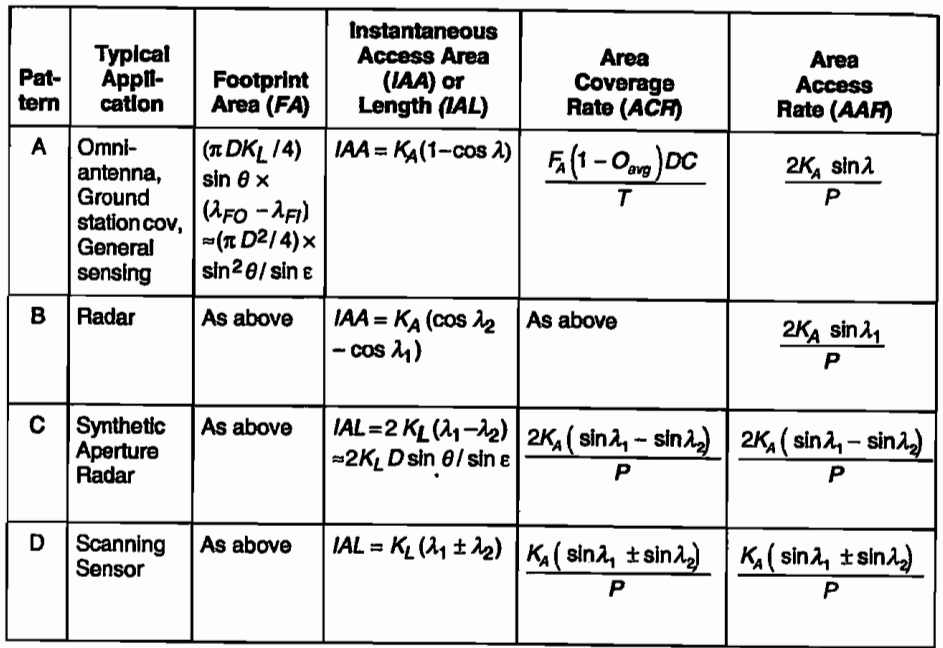

pg. 168 - SMAD

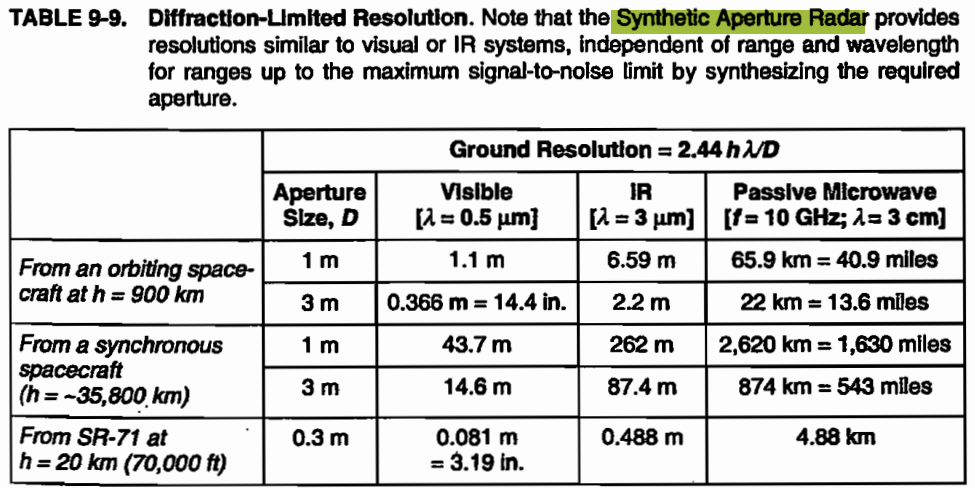

pg. 265 - SMAD

In [8]:
azimuth_resolution = 0.25 # meter
swath = 5 # 5 x 5 km
nominal_scene_size = swath
slant_range_resolution = 0.3 # m
look_angle_range_low = 25 # deg
look_angle_range_high = 50 # deg
# manipulate sizing of antenna to best fit mission requirements
# the size of the SAR antenna is likely going to be much bigger than initially expected


SAR System Parameters Calculations

In [9]:
# footprint
# antenna height
# incident angle
# platform height
# antenna length
# antenna beamwidth
# pulse width
# integration Time
# bandwidth
# peak power
# duty cycle
# PRF (pulse repetition frequency)

# according to MATLAB (a/c)  this is what we want from our SAR system:
slantrngres = 1;        # Required slant range resolution (m)
azres = 1;              # Required azimuth resolution (m)
maxrng = 10e3;          # Maximum unambiguous slant range (m)
pd = 0.9;               # Probability of detection
pfa = 1e-6;             # Probability of false alarm
v = 100;                # Velocity (m/s)
max_alt = 615000;       # Radar altitude (m) for worst-case scenario orbiting

In [10]:
# signal configuration
freq = 10e9;                 # Radar frequency within X-band (Hz)
# lambda = freq2wavelen(freq)  # Wavelength (m)

SAR Performance Parameters Calculations

In [11]:
# MATLAB PERFORMANCE PARAMETERS:
# Azimuth Resolution - Capella: 0.5m
# SNR 
# slant Range Resolution - capella: 0.3m
# Probability of detection
# probability of false alarm
# nominal scene size - capella: 5x5km 
# look angle range - capella: 25 deg to 50 deg

# CAPELLA PERFORMANCE PARAMETERS:
# Noise Equivalent Sigma Naught (NESZ) (check vekom)
# Range ambiguity to signal ratio (RASR)
# Azimuth Ambiguity to Signal Ratio (AASR)
# Peak Sidelobe Ratio (PSLR) = 10 log10 (Ipeak / Iside)
# Integrated Sidelobe Ratio (ISLR) = 10 log10(Emain/Eside)



Antenna

In [12]:
# for monostatic case (ours):

# Define transmitter antenna gain factor
def GA(Ae, λ):
    # Given parameters:
    # Ae: receiver antenna effective area (m^2)
    # λ: radar wavelength
    numerator = 4 * np.pi * Ae
    denominator = λ**2
    GA = numerator / denominator
    return GA

# Define effective area
def Ae(η_ap=0.5, AA):
    # Given parameters:
    # η_ap: aperture efficiency of the antenna
    # AA: physical area of the antenna aperture
    Ae = η_ap * AA
    return Ae



SyntaxError: parameter without a default follows parameter with a default (365957958.py, line 14)

Electronic Phased-Arrays

In [ ]:
# Electronically Steerable Array (ESA)
# Multi-Look
# define radar equation:
# def SNR_image(Pavg, η_ap, AA, f, σ, a_wa, v_x, R, ρ_a, T, FN, L_radar, L_atmos, Lr, La):
    # Given parameters:


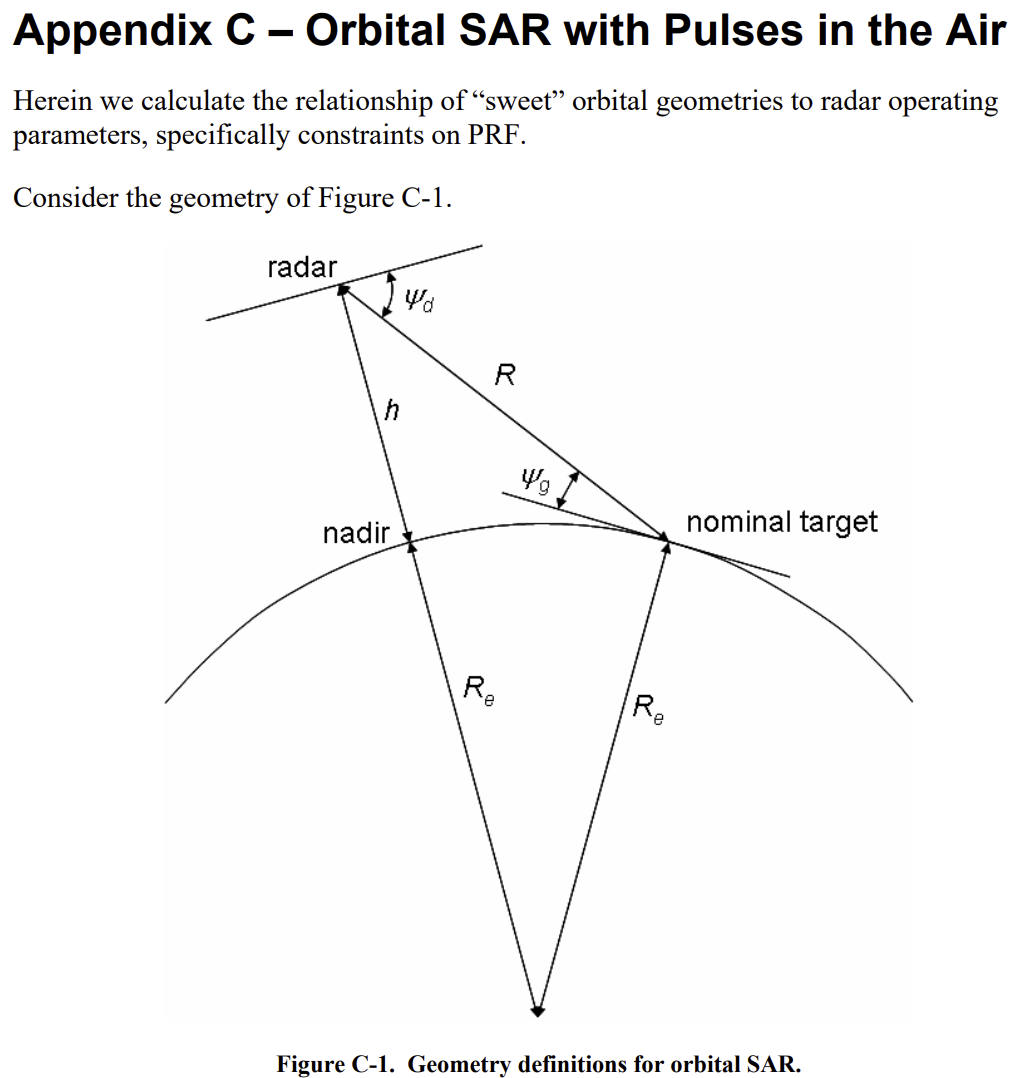

pg. 63 - Performance Limits for Synthetic Aperture Radar


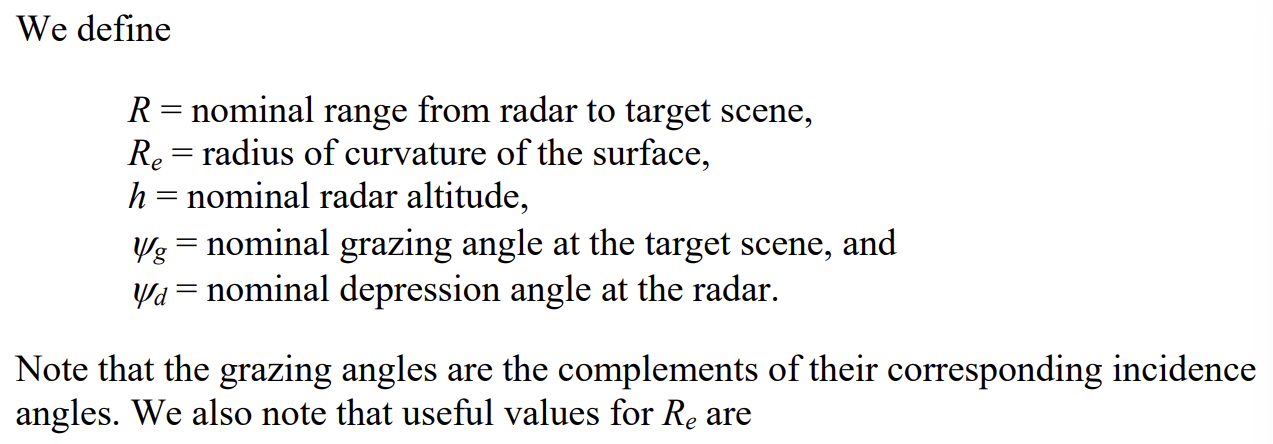

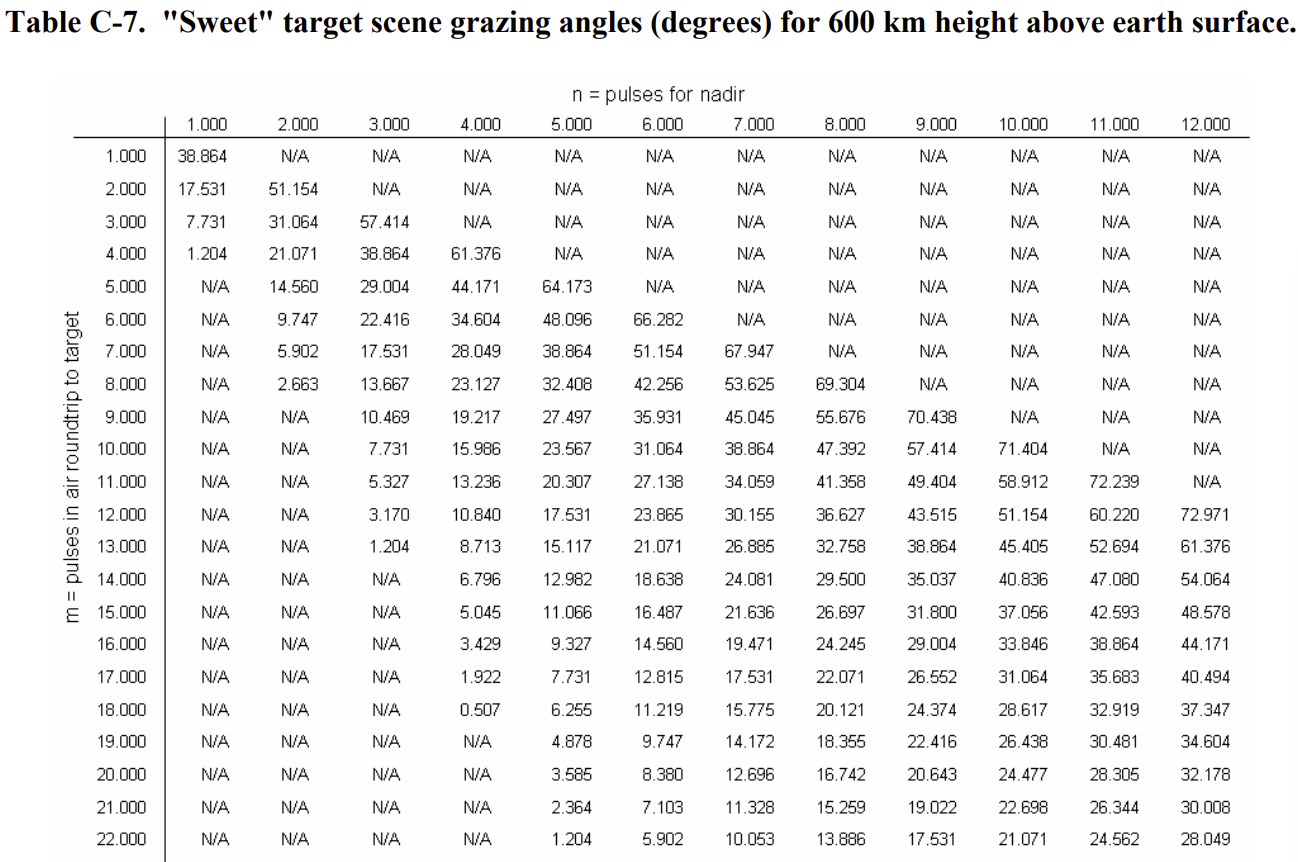